In [1]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
#from scipy.io import netcdf
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [3]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [4]:
# import freq df
freq_level =  pd.read_csv("dataset/modeling/sample/freq_sample.csv").set_index("proj_id")
print(freq_level.shape)
print(" ")
print("details: ")
print(f"daily_freq: {freq_level[freq_level['daily']].shape}")
print(f"mid_weekly_freq: {freq_level[freq_level['mid_weekly']].shape}")
print(f"weekly_freq: {freq_level[freq_level['weekly']].shape}")
print(f"fortnight_freq: {freq_level[freq_level['fortnight']].shape}")
print(f"low_freq_freq: {freq_level[freq_level['low_freq']].shape}")

freq_level

(25, 7)
 
details: 
daily_freq: (5, 7)
mid_weekly_freq: (5, 7)
weekly_freq: (5, 7)
fortnight_freq: (5, 7)
low_freq_freq: (5, 7)


,daily,mid_weekly,weekly,fortnight,low_freq,freq,length
proj_id,,,,,,,
BE_15166,True,False,False,False,False,1.0,615
TH_5229210601,True,False,False,False,False,1.0,2192
BE_5600,True,False,False,False,False,1.0,2829
BY_24158,True,False,False,False,False,1.0,4267
BE_209,True,False,False,False,False,1.0,5906
BY_6166,False,True,False,False,False,4.0,114
HE_12213,False,True,False,False,False,4.0,1376
NW_80303559,False,True,False,False,False,4.0,1489
NI_100000565,False,True,False,False,False,4.0,2607


In [5]:
# import t s and convert into date type
grouped_t_s = pd.read_csv("dataset/modeling/sample/sample_t_s.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
# drop colmns after 2011.11.30 bcs not existing in temp and prec
grouped_t_s= grouped_t_s.drop(grouped_t_s.columns[-33:-2],axis=1)
print(grouped_t_s.shape)
grouped_t_s.head()

(25, 6546)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,freq,length
proj_id,,,,,,,,,,,,,,,,,,,,,
BE_15166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,615
TH_5229210601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,502.21600,502.21075,502.20675,502.19800,502.21375,502.24650,502.44375,502.54375,1.0,2192
BE_5600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.06000,45.07000,45.08000,45.09000,45.10000,45.10000,45.13000,45.15000,1.0,2829
BY_24158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,413.13375,413.13917,413.15021,413.16542,413.17937,413.19063,413.21208,413.17188,1.0,4267
BE_209,33.87,33.87,33.8,33.8,33.81,33.85,33.82,33.81,33.86,33.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5906


In [6]:
# import ave_temp 
ave_temp = pd.read_csv("dataset/modeling/sample/sample_temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
print(ave_temp.shape)
ave_temp.head()


(25, 6545)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,freq
proj_id,,,,,,,,,,,,,,,,,,,,,
BE_15166,24.0,0.0,-9.0,-41.0,-60.0,-70.0,-61.0,-64.0,-18.0,22.0,...,62.0,36.0,65.0,82.0,70.0,79.0,62.0,41.0,19.0,1.0
TH_5229210601,-8.0,-26.0,-44.0,-97.0,-106.0,-99.0,-94.0,-98.0,-47.0,-2.0,...,37.0,34.0,50.0,69.0,56.0,55.0,37.0,2.0,-17.0,1.0
BE_5600,23.0,-1.0,-10.0,-43.0,-62.0,-72.0,-63.0,-65.0,-19.0,22.0,...,60.0,35.0,64.0,81.0,67.0,77.0,61.0,41.0,18.0,1.0
BY_24158,8.0,-21.0,-41.0,-79.0,-95.0,-94.0,-90.0,-80.0,-46.0,6.0,...,43.0,44.0,42.0,60.0,49.0,62.0,58.0,9.0,-4.0,1.0
BE_209,23.0,0.0,-8.0,-43.0,-60.0,-70.0,-61.0,-65.0,-18.0,22.0,...,62.0,35.0,65.0,81.0,68.0,78.0,61.0,42.0,20.0,1.0


In [7]:
# import the cum_prec 
cum_prec=pd.read_csv("dataset/modeling/sample/sample_prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(cum_prec.shape)
cum_prec.head()

(25, 6545)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,freq
proj_id,,,,,,,,,,,,,,,,,,,,,
BE_15166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,33.0,10.0,1.0,11.0,29.0,55.0,151.0,2.0,1.0
TH_5229210601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,69.0,69.0,272.0,140.0,2.0,1.0
BE_5600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,33.0,10.0,1.0,11.0,33.0,57.0,156.0,2.0,1.0
BY_24158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,145.0,152.0,0.0,1.0
BE_209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,35.0,12.0,0.0,14.0,19.0,90.0,193.0,3.0,1.0


In [8]:
#######################################################################################

# Func

In [45]:
# create df for a t s (one row in grouped_t_s df)
def create_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[:-2]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df
####################################################################

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
##################################################################################

def split_df(reframed, n_lag, n_features):
    # split into train and test sets
    values = reframed.values
    n_train = int(len(reframed)*0.8)
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    n_obs = n_lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
    return train_X, train_y, test_X, test_y



# pick t s

In [50]:
# apply the func
ts1 = grouped_t_s.iloc[4]
df = create_ts_df(ts1)
print(df.shape)

(5906, 3)


In [51]:
ts1

1995-01-01      33.87
1995-01-02      33.87
1995-01-03      33.80
1995-01-04      33.80
1995-01-05      33.81
               ...   
2012-11-28        NaN
2012-11-29        NaN
2012-11-30        NaN
freq             1.00
length        5906.00
Name: BE_209, Length: 6546, dtype: float64

Text(0.5, 1.0, 'prec')

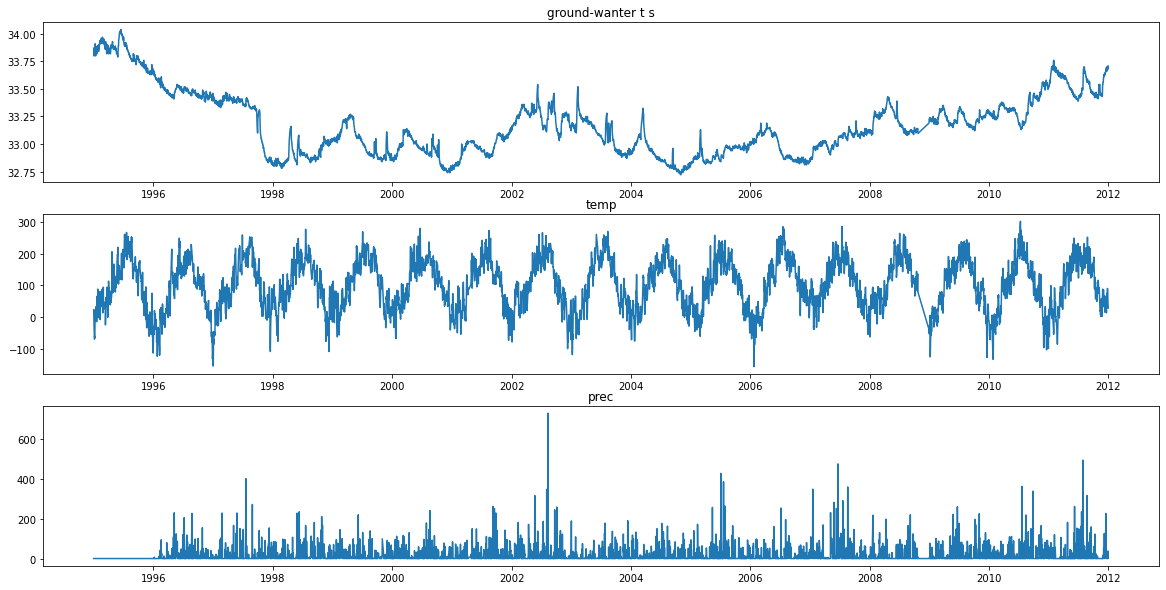

In [52]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,400
axs[0].plot(df["ts"])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"])
axs[1].set_title('temp')
axs[2].plot(df["prec"])
axs[2].set_title('prec')

# apply

(5896, 33)
(4716, 20) 4716 (4716,)
input to be 3D [samples, timesteps(lag, features]

train: (4716, 10, 2) , (4716,) ,test: (1180, 10, 2) , (1180,)
Epoch 1/50
66/66 - 3s - loss: 0.1314 - val_loss: 0.1185
Epoch 2/50
66/66 - 0s - loss: 0.1320 - val_loss: 0.1383
Epoch 3/50
66/66 - 0s - loss: 0.1214 - val_loss: 0.1258
Epoch 4/50
66/66 - 0s - loss: 0.1127 - val_loss: 0.1183
Epoch 5/50
66/66 - 0s - loss: 0.1060 - val_loss: 0.1082
Epoch 6/50
66/66 - 0s - loss: 0.0976 - val_loss: 0.0965
Epoch 7/50
66/66 - 0s - loss: 0.0882 - val_loss: 0.0854
Epoch 8/50
66/66 - 0s - loss: 0.0788 - val_loss: 0.0742
Epoch 9/50
66/66 - 0s - loss: 0.0715 - val_loss: 0.0685
Epoch 10/50
66/66 - 1s - loss: 0.0688 - val_loss: 0.0678
Epoch 11/50
66/66 - 0s - loss: 0.0686 - val_loss: 0.0677
Epoch 12/50
66/66 - 0s - loss: 0.0686 - val_loss: 0.0676
Epoch 13/50
66/66 - 0s - loss: 0.0685 - val_loss: 0.0675
Epoch 14/50
66/66 - 0s - loss: 0.0685 - val_loss: 0.0675
Epoch 15/50
66/66 - 0s - loss: 0.0685 - val_loss: 0.0675
Epoch 

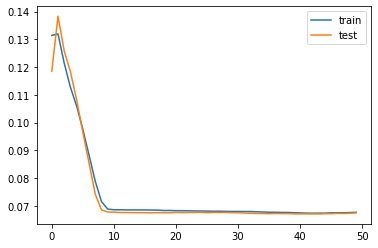

Test RMSE: 0.113


In [53]:
#######################################################

# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_lag = 10 
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, 1)
print(reframed.shape)
####################################################################


train_X, train_y, test_X, test_y= split_df(reframed, n_lag, n_features)
print("input to be 3D [samples, timesteps(lag, features]\n")
print(f"train: {train_X.shape} , {train_y.shape} ,test: {test_X.shape} , {test_y.shape}")
#################################################################################


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#################################################################################################


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -2:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -2:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
########################################################################################



# lag =10

## there is a mistake !!!!

<AxesSubplot:>

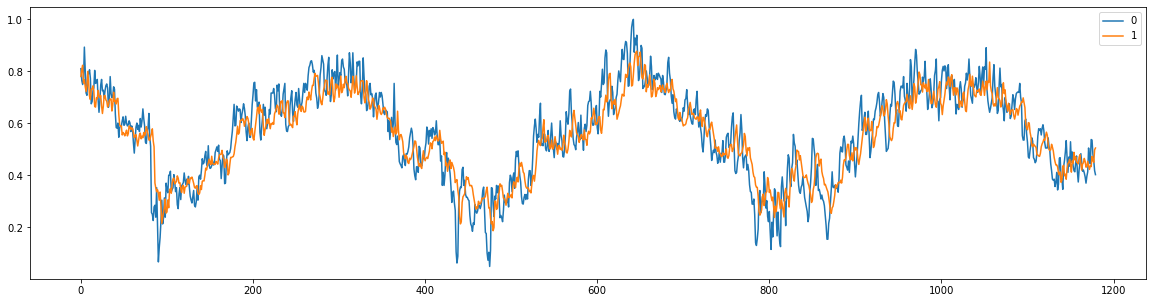

In [68]:
fd = pd.DataFrame([test_y.T[0], yhat.T[0]]).T

fd.plot(figsize=(20,5))

In [ ]:
#################################looooooop

In [ ]:
err = []
for i in range(0,25):
    ts = grouped_t_s.iloc[i]
    inv_yhat, inv_y, rmse = modeling_n_lag(ts)
    err.append(rmse)
    
# plot yhat and ytest
plt.bar(range(0,len(err)-17), err[:-17])


In [ ]:
print(f"rmse: {round(rmse,3)}")
fd = pd.DataFrame([inv_y, inv_yhat]).T
fd.plot(figsize=(20,5))